<a href="https://colab.research.google.com/github/sonishrey9/General_purpose_EDA_using_pyspark/blob/main/General_purpose_EDA_using_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=5e465c02575130dcf76efe82818b4c70525734d2a3315d3acc596f02d9fb78a2
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, mean, sum, stddev, count, lit, when
from pyspark.sql.types import FloatType
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  -122.05|   37.37|              27.0|     3885.0|         661.0|    1537.0|     606.0|       6.6085|          344700.0|
|   -118.3|   34.26|              43.0|     1510.0|         310.0|     809.0|     277.0|        3.599|          176500.0|
|  -117.81|   33.78|              27.0|     3589.0|         507.0|    1484.0|     495.0|       5.7934|          270500.0|
|  -118.36|   33.82|              28.0|       67.0|          15.0|      49.0|      11.0|       6.1359|          330000.0|
|  -119.67|   36.33|              19.0|     1241.0|         244.0|     850.0|     237.0|       2.9375|           81700.0|
|  -119.56|   36.51|    

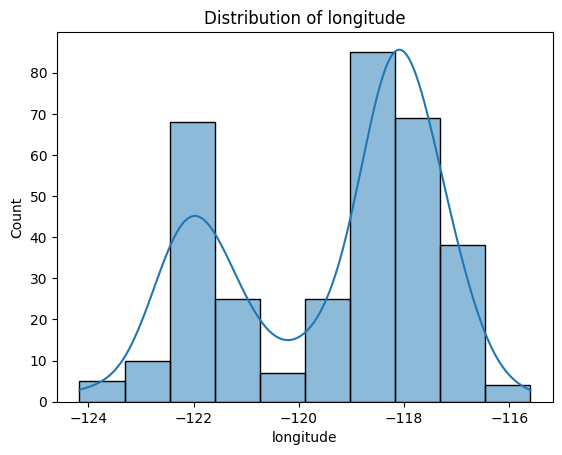

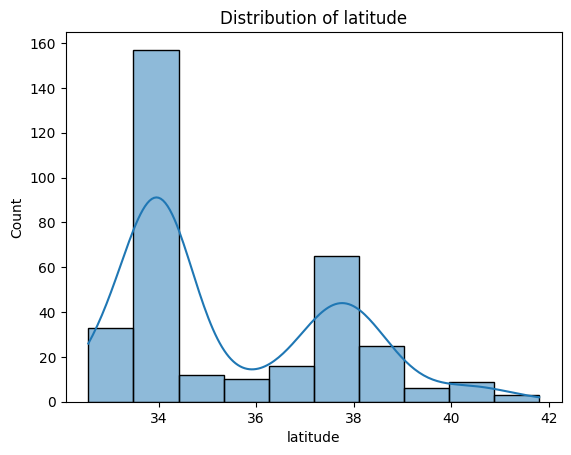

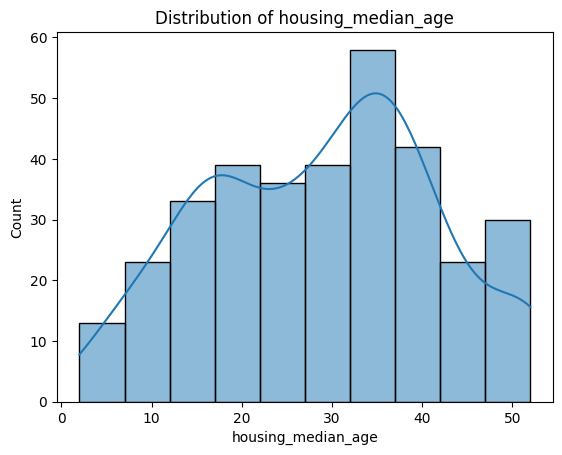

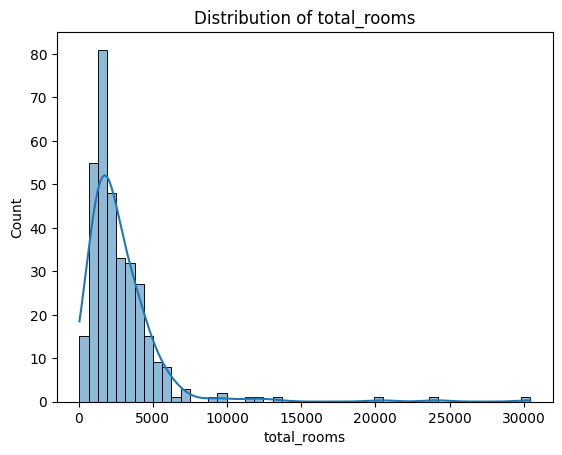

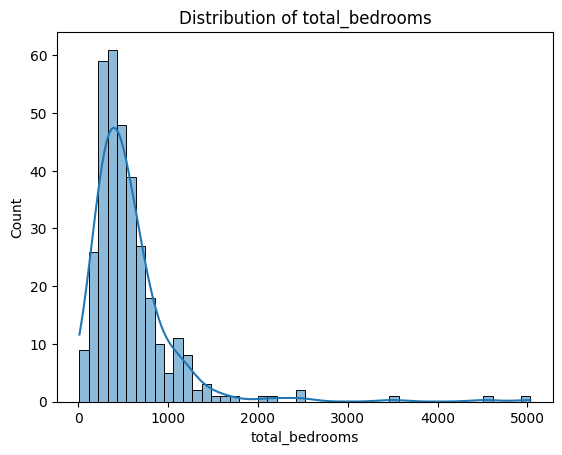

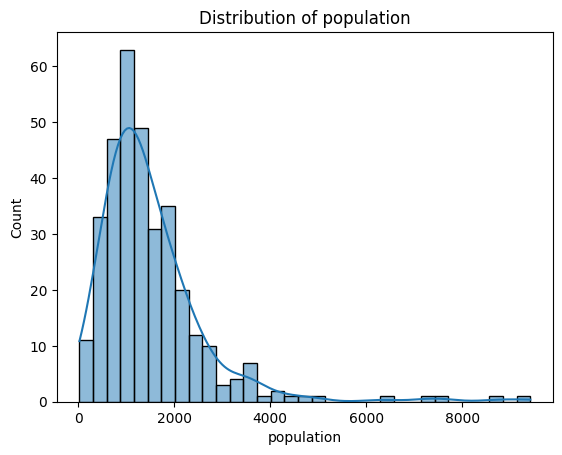

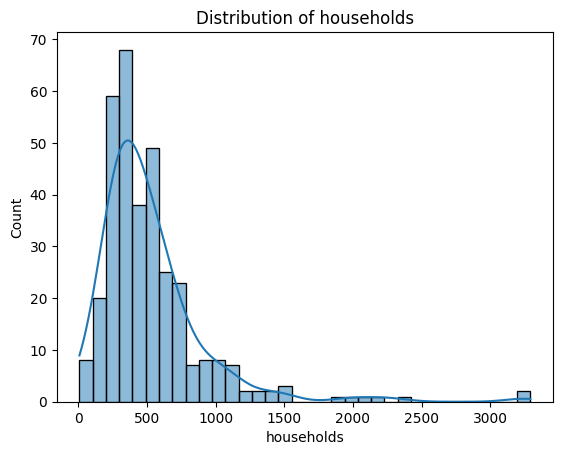

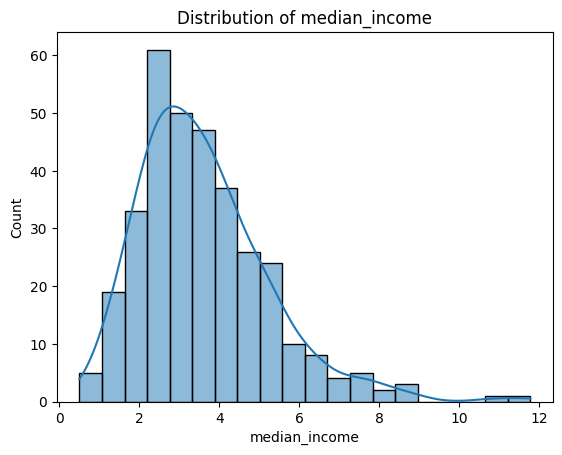

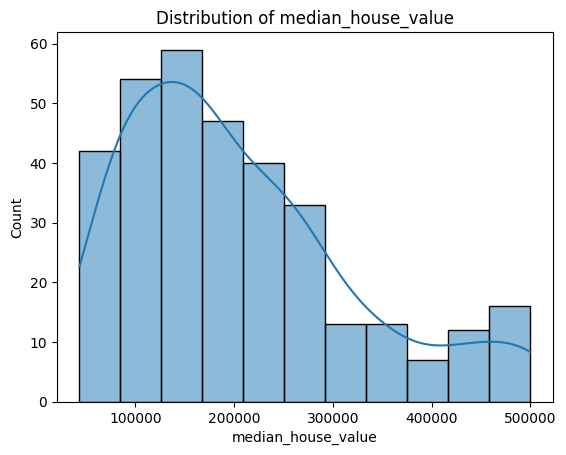

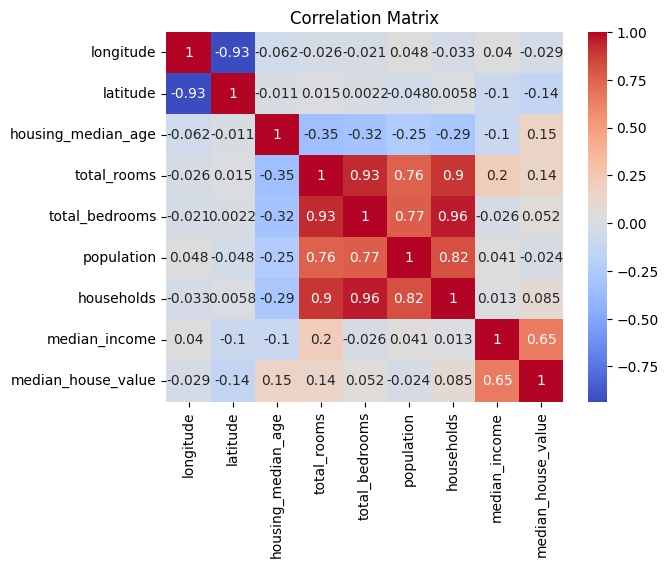

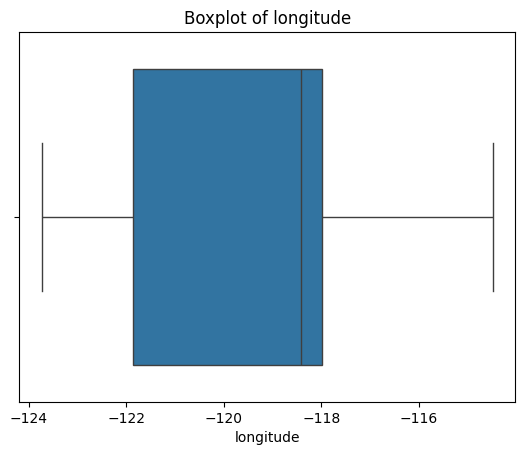

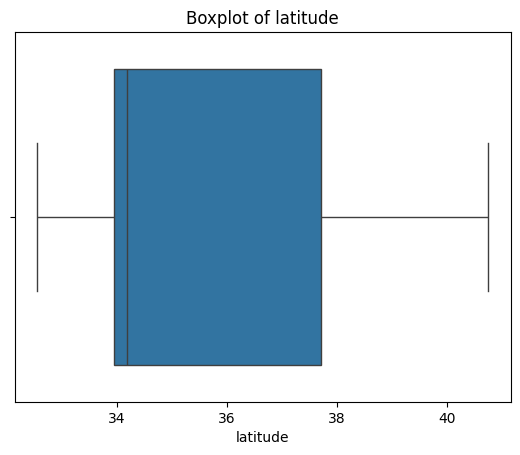

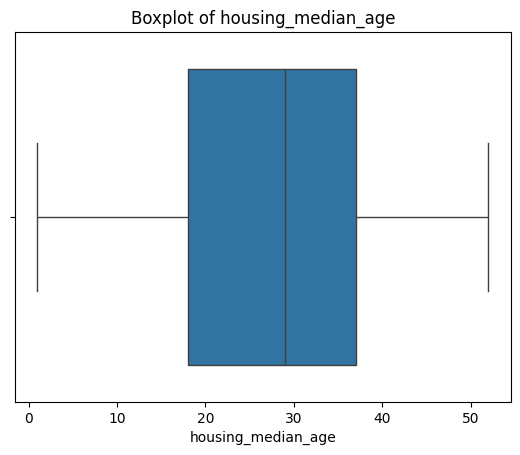

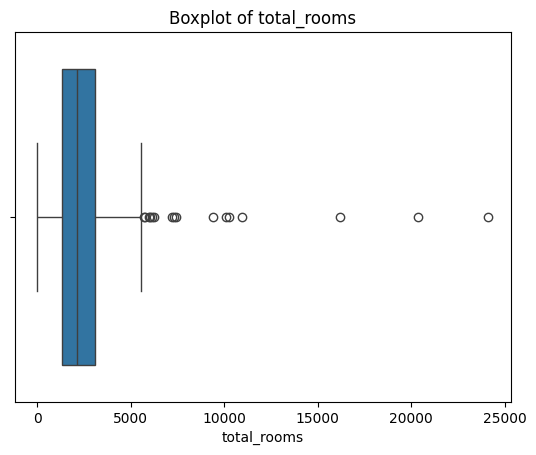

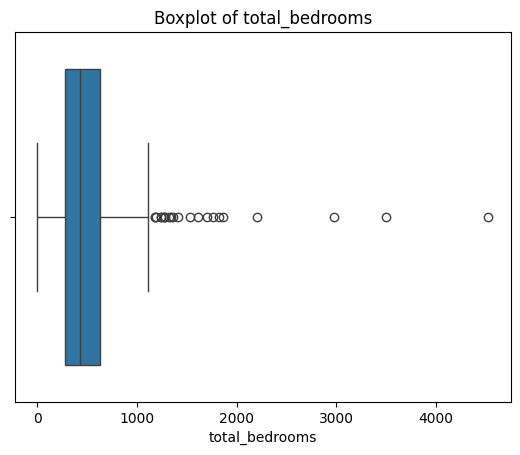

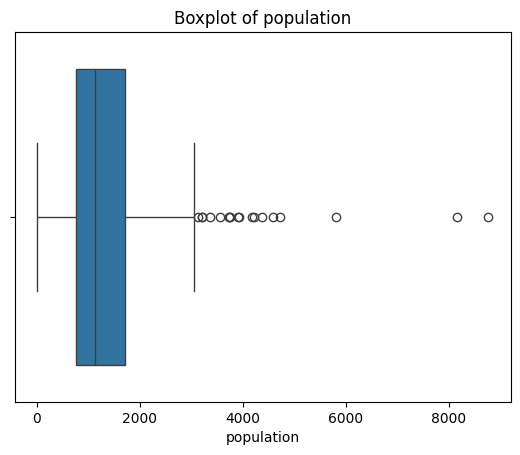

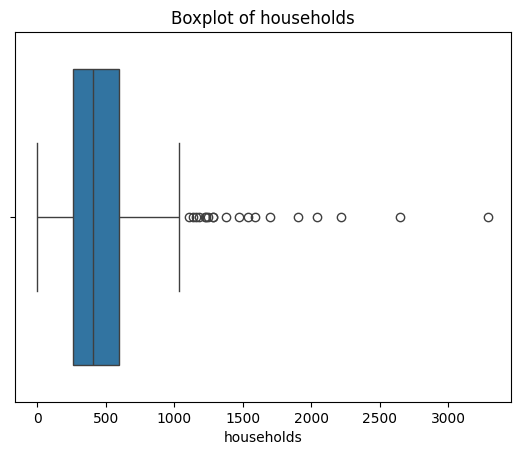

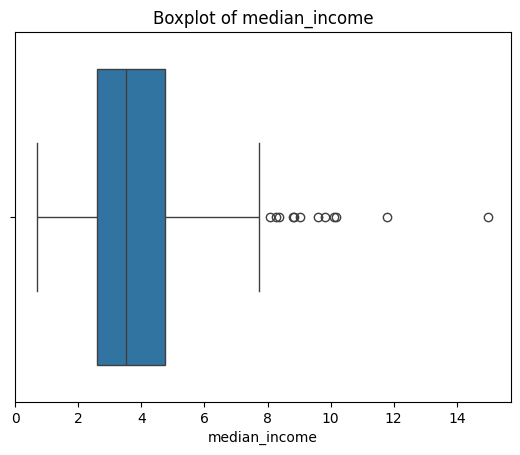

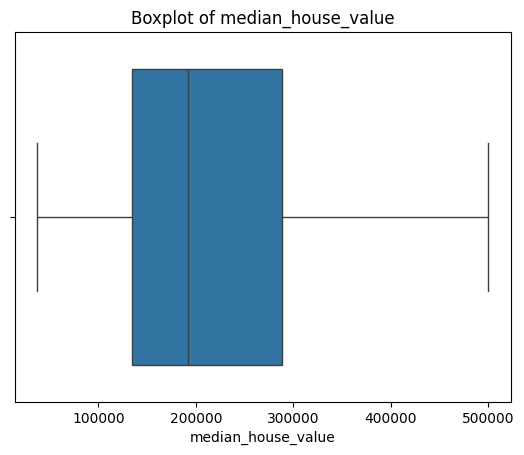

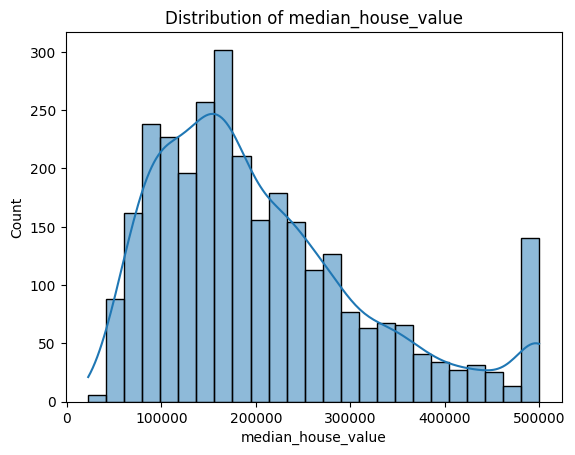

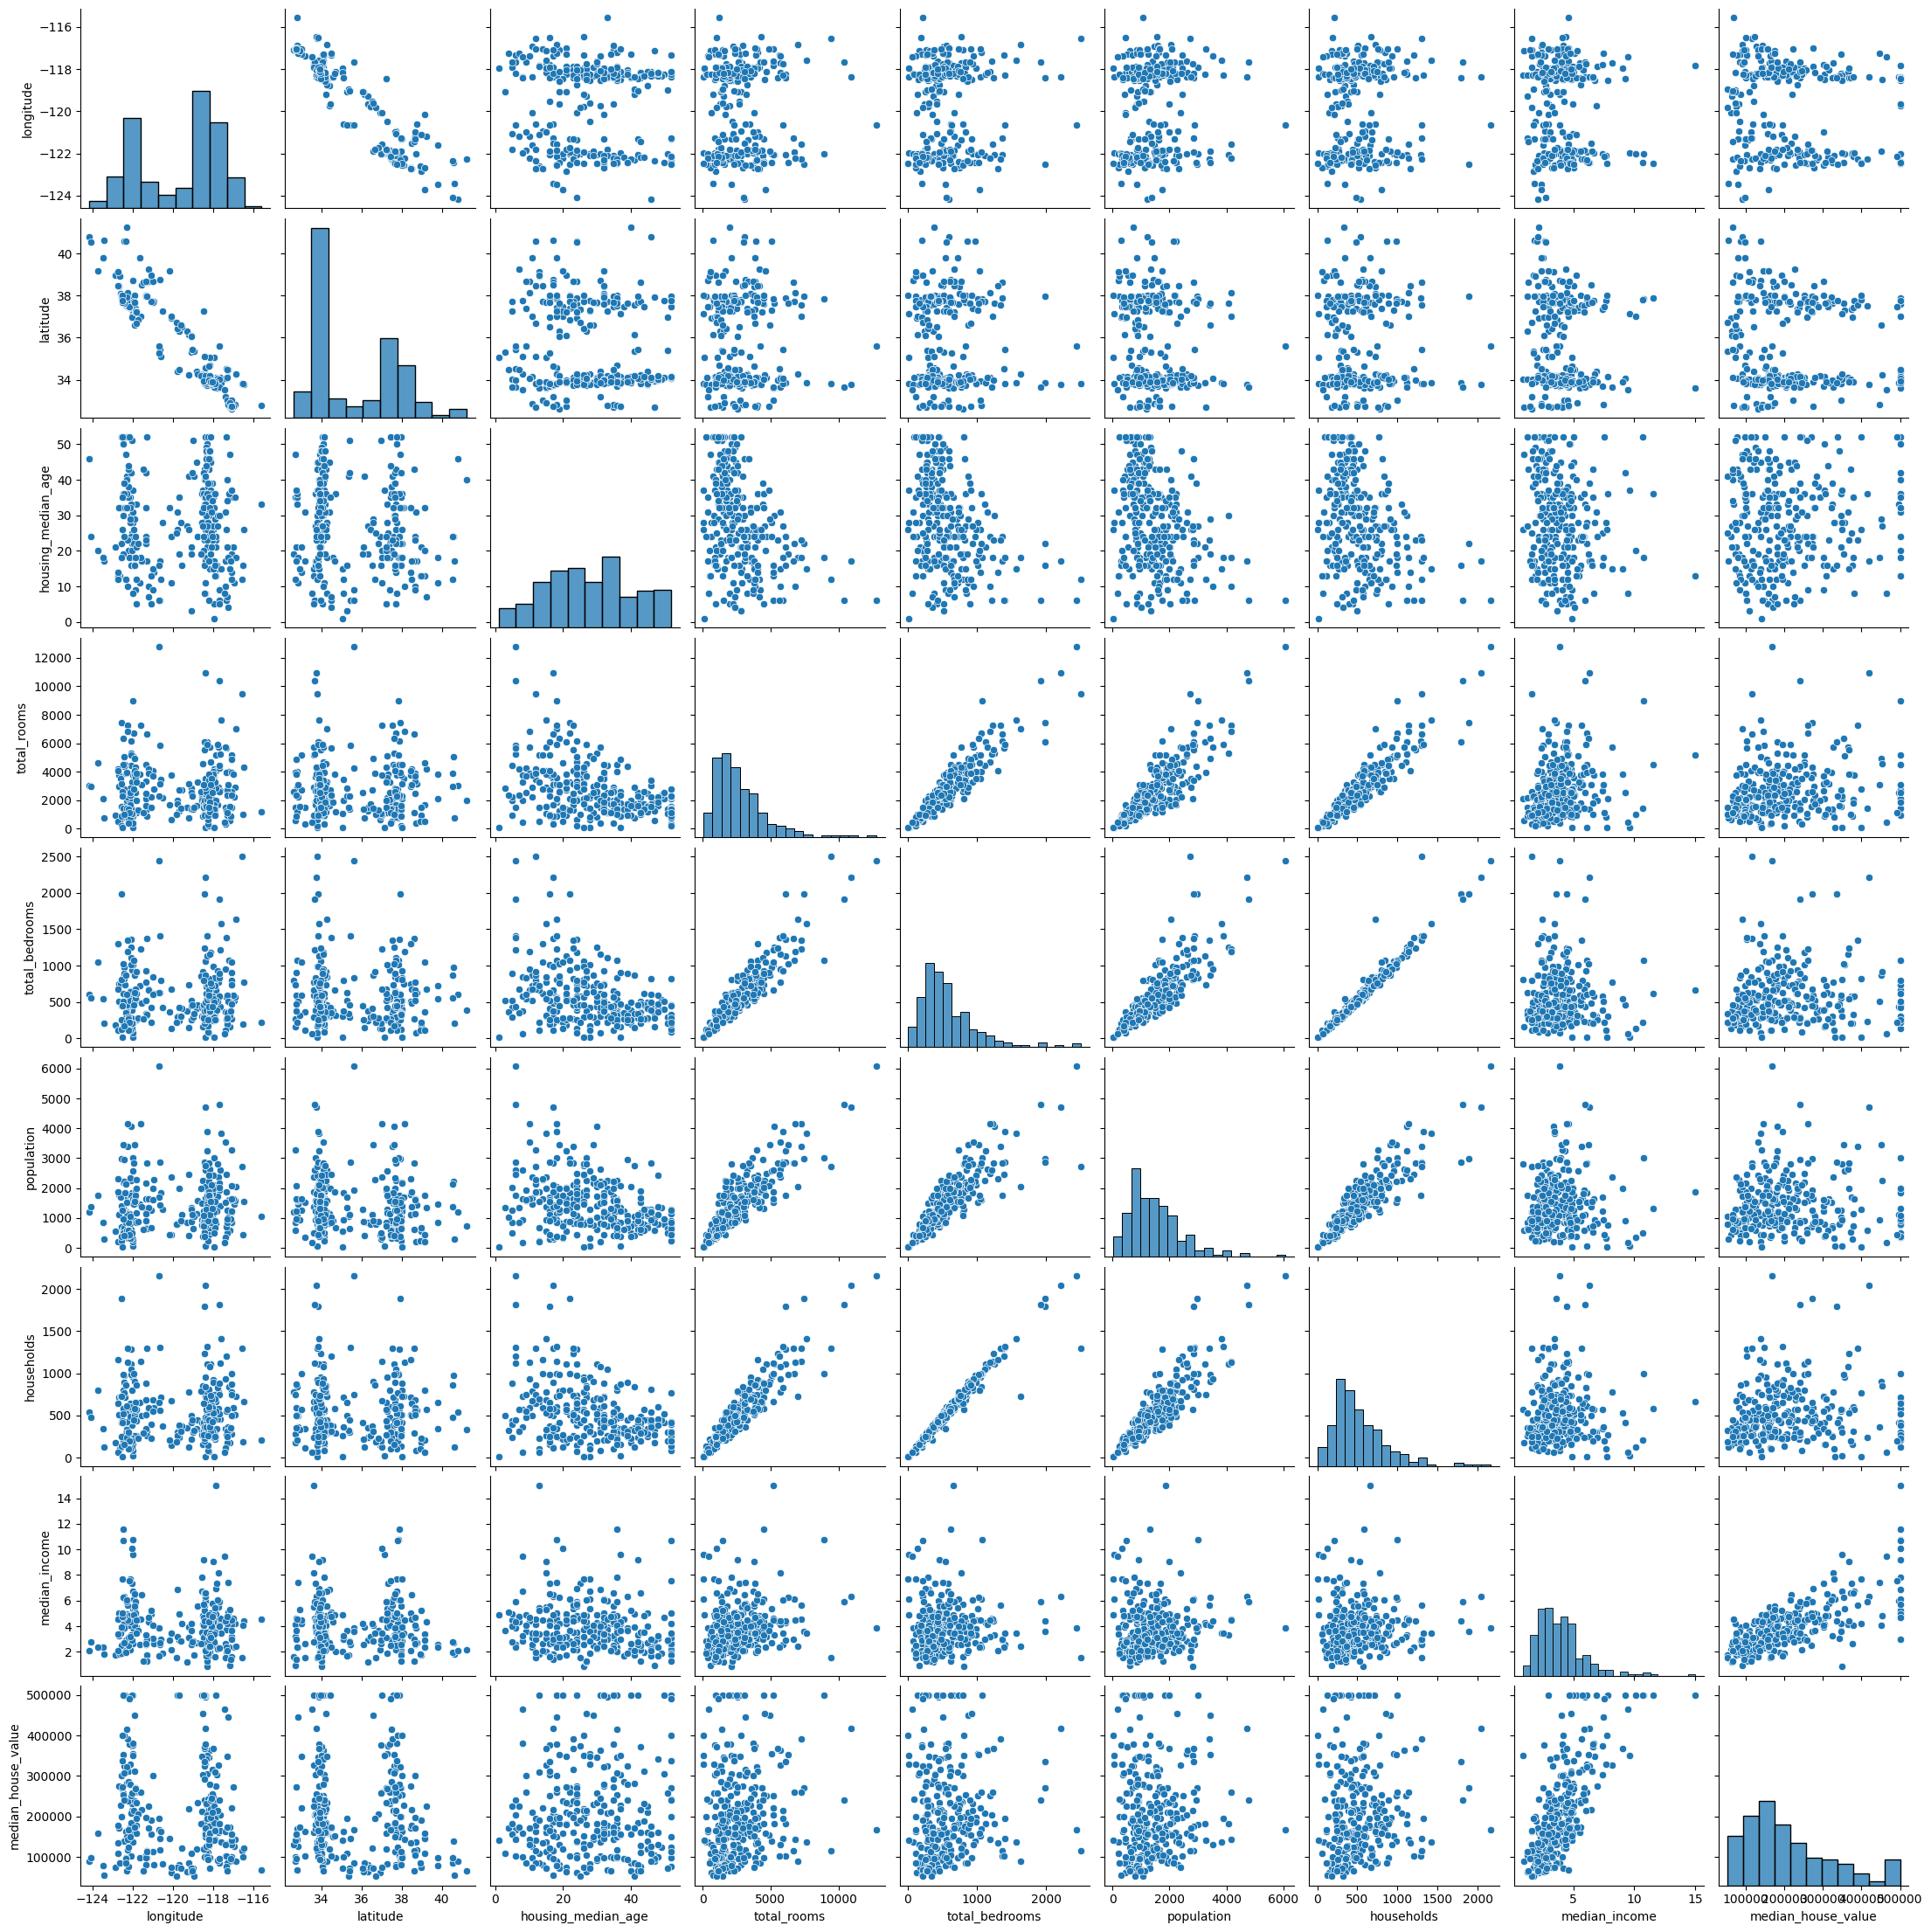

Not enough suitable columns found for summary statistics (need one categorical and one numerical).


In [4]:


# Initialize Spark Session
def initialize_spark(app_name="PySpark EDA"):
    spark = SparkSession.builder.appName(app_name).getOrCreate()
    return spark

# Load Data
def load_data(spark, file_path, file_type='csv'):
    if file_type == 'csv':
        return spark.read.csv(file_path, header=True, inferSchema=True)
    elif file_type == 'json':
        return spark.read.json(file_path)
    else:
        raise ValueError("Unsupported file type")

# Basic Info
def basic_info(df):
    df.show()
    df.printSchema()
    df.describe().show()

# Missing Values
def missing_values(df):
    for col_name in df.columns:
        missing_count = df.filter(col(col_name).isNull()).count()
        print(f"{col_name}: {missing_count} missing values")

# Identify Numerical and Categorical Columns
def identify_columns(df):
    data_types = dict(df.dtypes)
    numerical_columns = [column for column, dtype in data_types.items() if dtype in ['int', 'float', 'double']]
    categorical_columns = []

    for column, dtype in data_types.items():
        if dtype == 'string':
            casted_column = df.withColumn(column, col(column).cast(FloatType()))
            non_null_count = casted_column.filter(col(column).isNotNull()).count()
            if non_null_count / df.count() > 0.95:
                numerical_columns.append(column)
            else:
                categorical_columns.append(column)

    print("Numerical Columns:", numerical_columns)
    print("Categorical Columns:", categorical_columns)
    return numerical_columns, categorical_columns

# Plot Distributions
def plot_distributions(df, numerical_columns):
    pandas_df = df.sample(fraction=0.1).toPandas()
    for column in numerical_columns:
        sns.histplot(pandas_df[column], kde=True)
        plt.title(f'Distribution of {column}')
        plt.show()

# Plot Categorical Columns
def plot_categorical(df, categorical_columns):
    pandas_df = df.sample(fraction=0.1).toPandas()
    for column in categorical_columns:
        sns.countplot(y=column, data=pandas_df)
        plt.title(f'Count plot of {column}')
        plt.show()

# Correlation Matrix
def correlation_matrix(df):
    pandas_df = df.sample(fraction=0.1).toPandas()
    # Select only numerical columns for correlation calculation
    numerical_df = pandas_df.select_dtypes(include=['number'])  # Filter numerical columns
    corr = numerical_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

# Outlier Detection
def detect_outliers(df, numerical_columns):
    pandas_df = df.sample(fraction=0.1).toPandas()
    for column in numerical_columns:
        sns.boxplot(x=pandas_df[column])
        plt.title(f'Boxplot of {column}')
        plt.show()

# Feature Engineering Example
def feature_engineering(df):
    # Example: Extracting year, month, and day from a date column
    if 'date_column' in df.columns:
        df = df.withColumn('year', F.year(col('date_column')))
        df = df.withColumn('month', F.month(col('date_column')))
        df = df.withColumn('day', F.dayofmonth(col('date_column')))
    return df

# Target Variable Analysis
def target_variable_analysis(df, target_column):
    sns.histplot(df.select(target_column).toPandas()[target_column], kde=True)
    plt.title(f'Distribution of {target_column}')
    plt.show()

# Pairwise Plots
def pairwise_plots(df, numerical_columns):
    pandas_df = df.sample(fraction=0.1).toPandas()
    sns.pairplot(pandas_df[numerical_columns])
    plt.show()

# Missing Value Imputation
def impute_missing_values(df):
    # Example: Fill missing values with the mean of the column
    for column in df.columns:
        # Check if mean_value is not None before imputing
        mean_value = df.select(mean(col(column))).collect()[0][0]
        if mean_value is not None:
            df = df.fillna({column: mean_value})
        else:
            print(f"Skipping imputation for column {column} as mean is None.")
    return df

# Summary Statistics by Group
def summary_statistics_by_group(df):
    try:
        # Automatically find a categorical and a numerical column
        categorical_column = next((col for col, dtype in df.dtypes if dtype == 'string'), None)
        numerical_column = next((col for col, dtype in df.dtypes if dtype in ['int', 'float', 'double']), None)

        if categorical_column and numerical_column:
            grouped_df = df.groupBy(categorical_column).agg(
                mean(numerical_column).alias('mean_numerical'),
                stddev(numerical_column).alias('stddev_numerical')
            )
            grouped_df.show()
        else:
            print("Not enough suitable columns found for summary statistics (need one categorical and one numerical).")

    except Exception as e:
        print(f"Error during summary statistics calculation: {e}")

# Categorical Variable Encoding
def encode_categorical(df, categorical_columns):
    from pyspark.ml.feature import StringIndexer
    indexers = [StringIndexer(inputCol=column, outputCol=column+"_indexed") for column in categorical_columns]
    from pyspark.ml import Pipeline
    pipeline = Pipeline(stages=indexers)
    df = pipeline.fit(df).transform(df)
    return df

# Detect Potential Target Variable
def detect_target_variable(df):
    numerical_columns, _ = identify_columns(df)
    if len(numerical_columns) > 0:
        target_column = numerical_columns[-1]  # Heuristic: Last numerical column
        print(f"Detected potential target variable: {target_column}")
        return target_column
    else:
        print("No numerical columns detected. Unable to identify target variable.")
        return None

# Full EDA Pipeline
def eda_pipeline(file_path, file_type='csv'):
    spark = initialize_spark()

    # Load data
    df = load_data(spark, file_path, file_type)

    # Basic Info
    basic_info(df)

    # Missing Values
    missing_values(df)

    # Identify Columns
    numerical_columns, categorical_columns = identify_columns(df)

    # Detect Target Variable
    target_column = detect_target_variable(df)

    # Plot Distributions for Numerical Columns
    plot_distributions(df, numerical_columns)

    # Plot Distributions for Categorical Columns
    plot_categorical(df, categorical_columns)

    # Correlation Matrix
    correlation_matrix(df)

    # Detect Outliers
    detect_outliers(df, numerical_columns)

    # Feature Engineering
    df = feature_engineering(df)

    # Target Variable Analysis
    if target_column:
        target_variable_analysis(df, target_column)

    # Pairwise Plots
    pairwise_plots(df, numerical_columns)

    # Impute Missing Values
    df = impute_missing_values(df)

    # Summary Statistics by Group (example)

    summary_statistics_by_group(df)

    # Encode Categorical Variables
    df = encode_categorical(df, categorical_columns)

    spark.stop()

# Example usage
eda_pipeline(r'/content/sample_data/california_housing_test.csv')


+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  -122.05|   37.37|              27.0|     3885.0|         661.0|    1537.0|     606.0|       6.6085|          344700.0|
|   -118.3|   34.26|              43.0|     1510.0|         310.0|     809.0|     277.0|        3.599|          176500.0|
|  -117.81|   33.78|              27.0|     3589.0|         507.0|    1484.0|     495.0|       5.7934|          270500.0|
|  -118.36|   33.82|              28.0|       67.0|          15.0|      49.0|      11.0|       6.1359|          330000.0|
|  -119.67|   36.33|              19.0|     1241.0|         244.0|     850.0|     237.0|       2.9375|           81700.0|
|  -119.56|   36.51|    

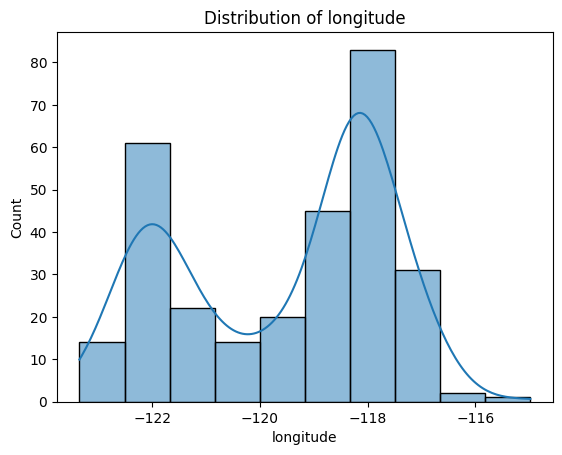

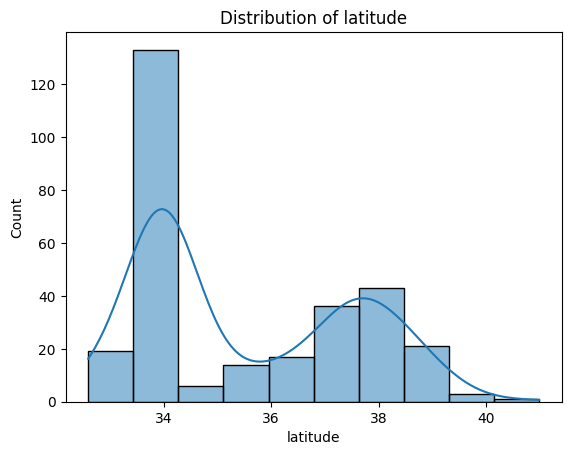

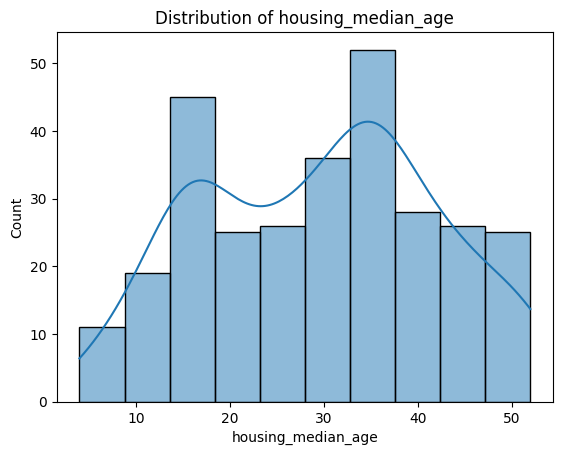

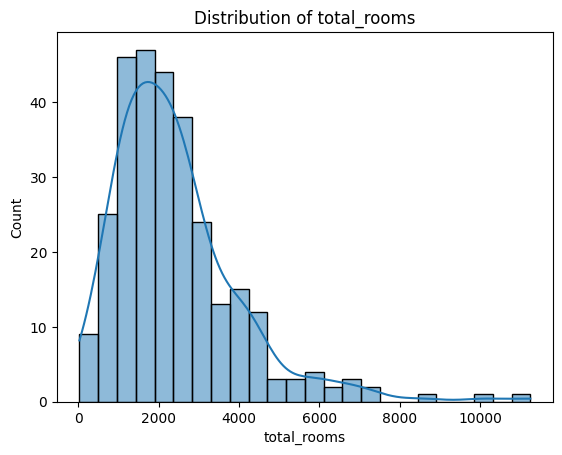

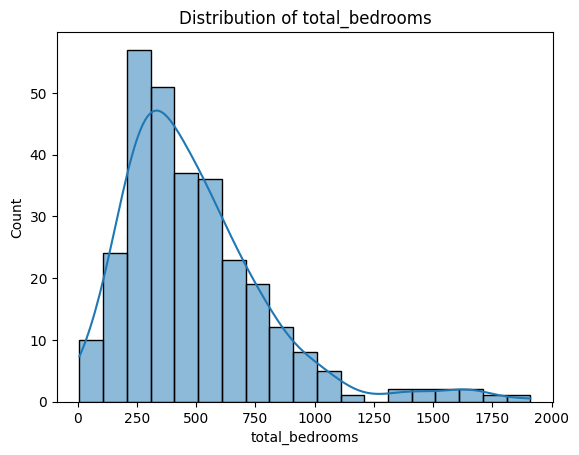

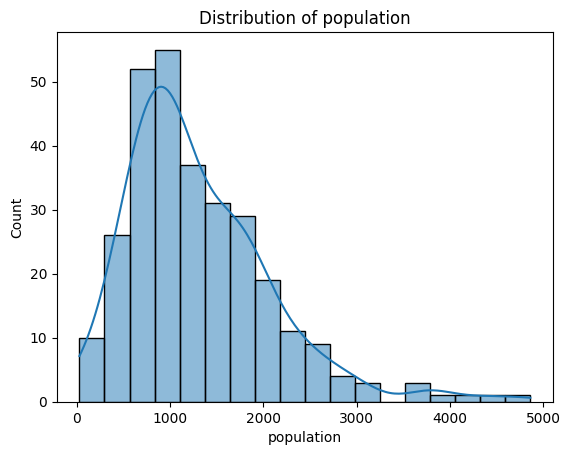

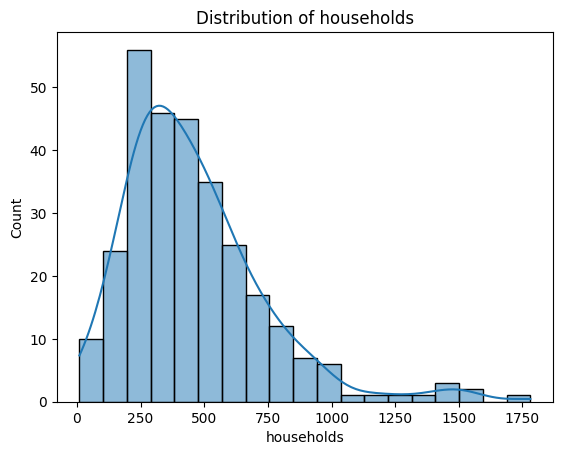

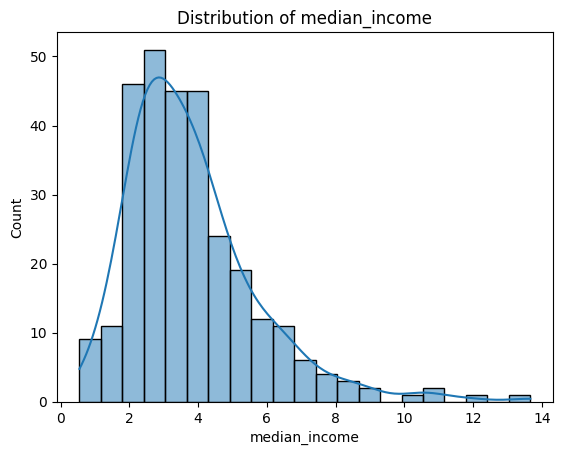

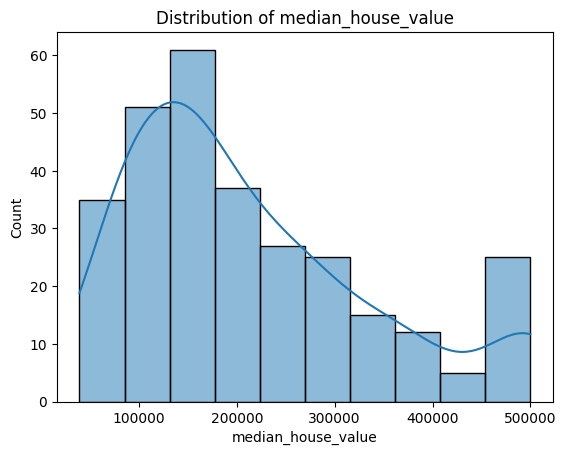

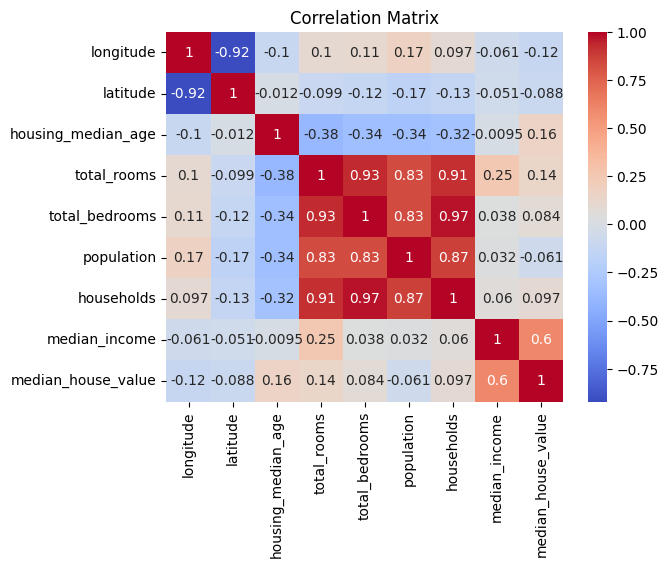

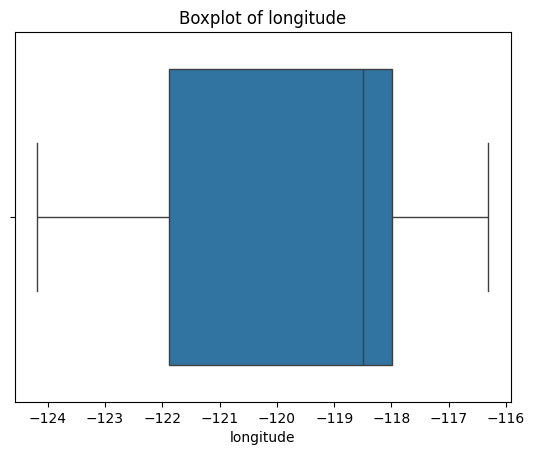

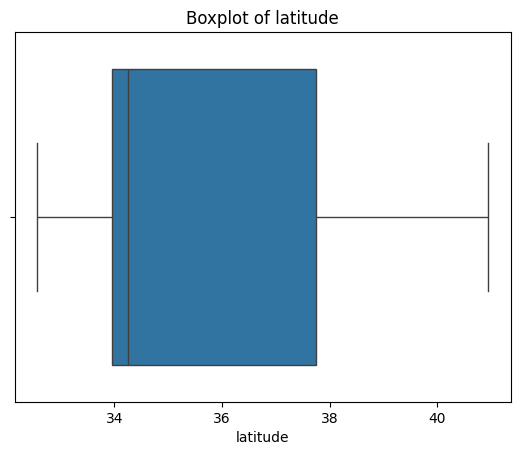

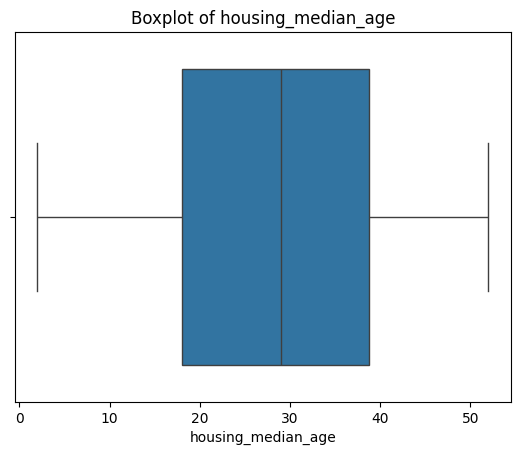

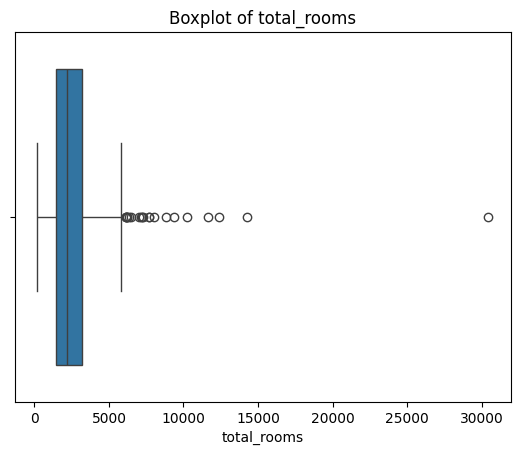

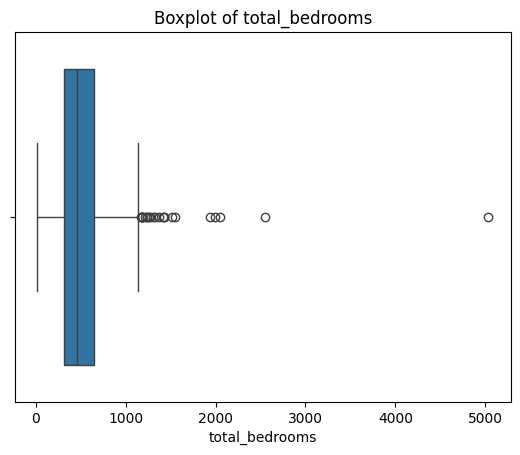

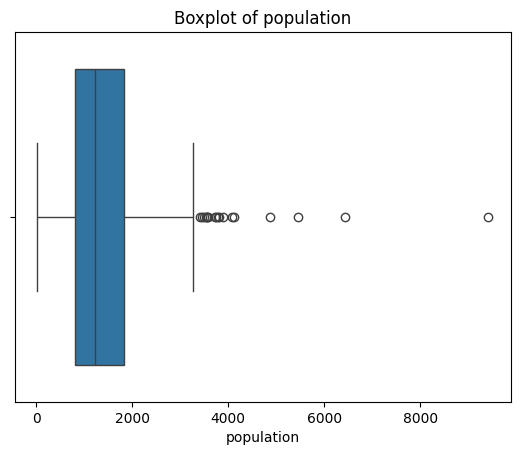

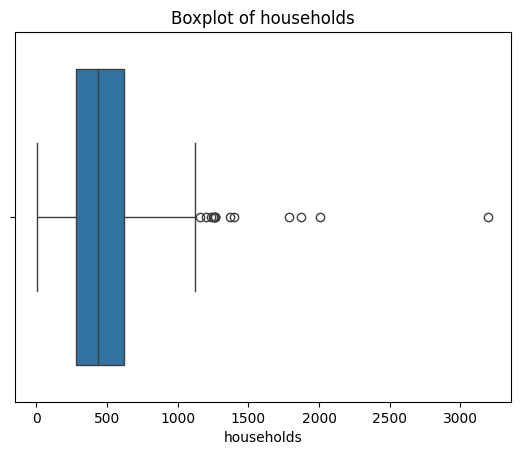

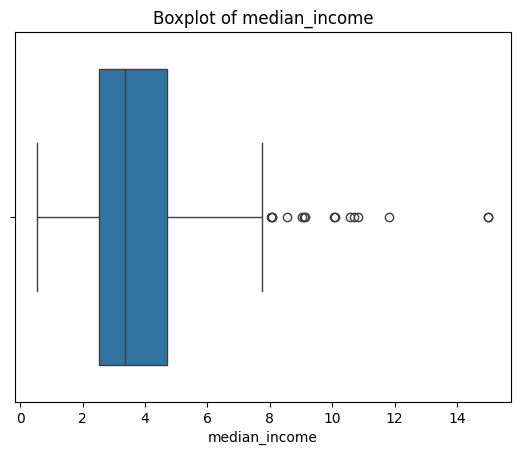

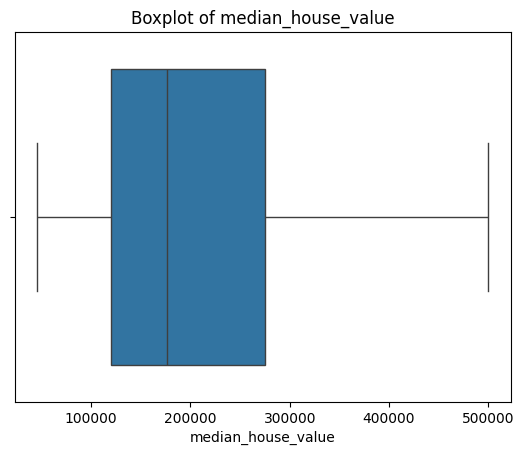

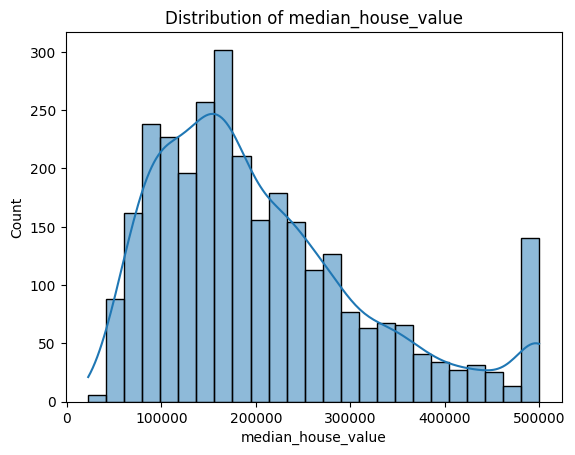

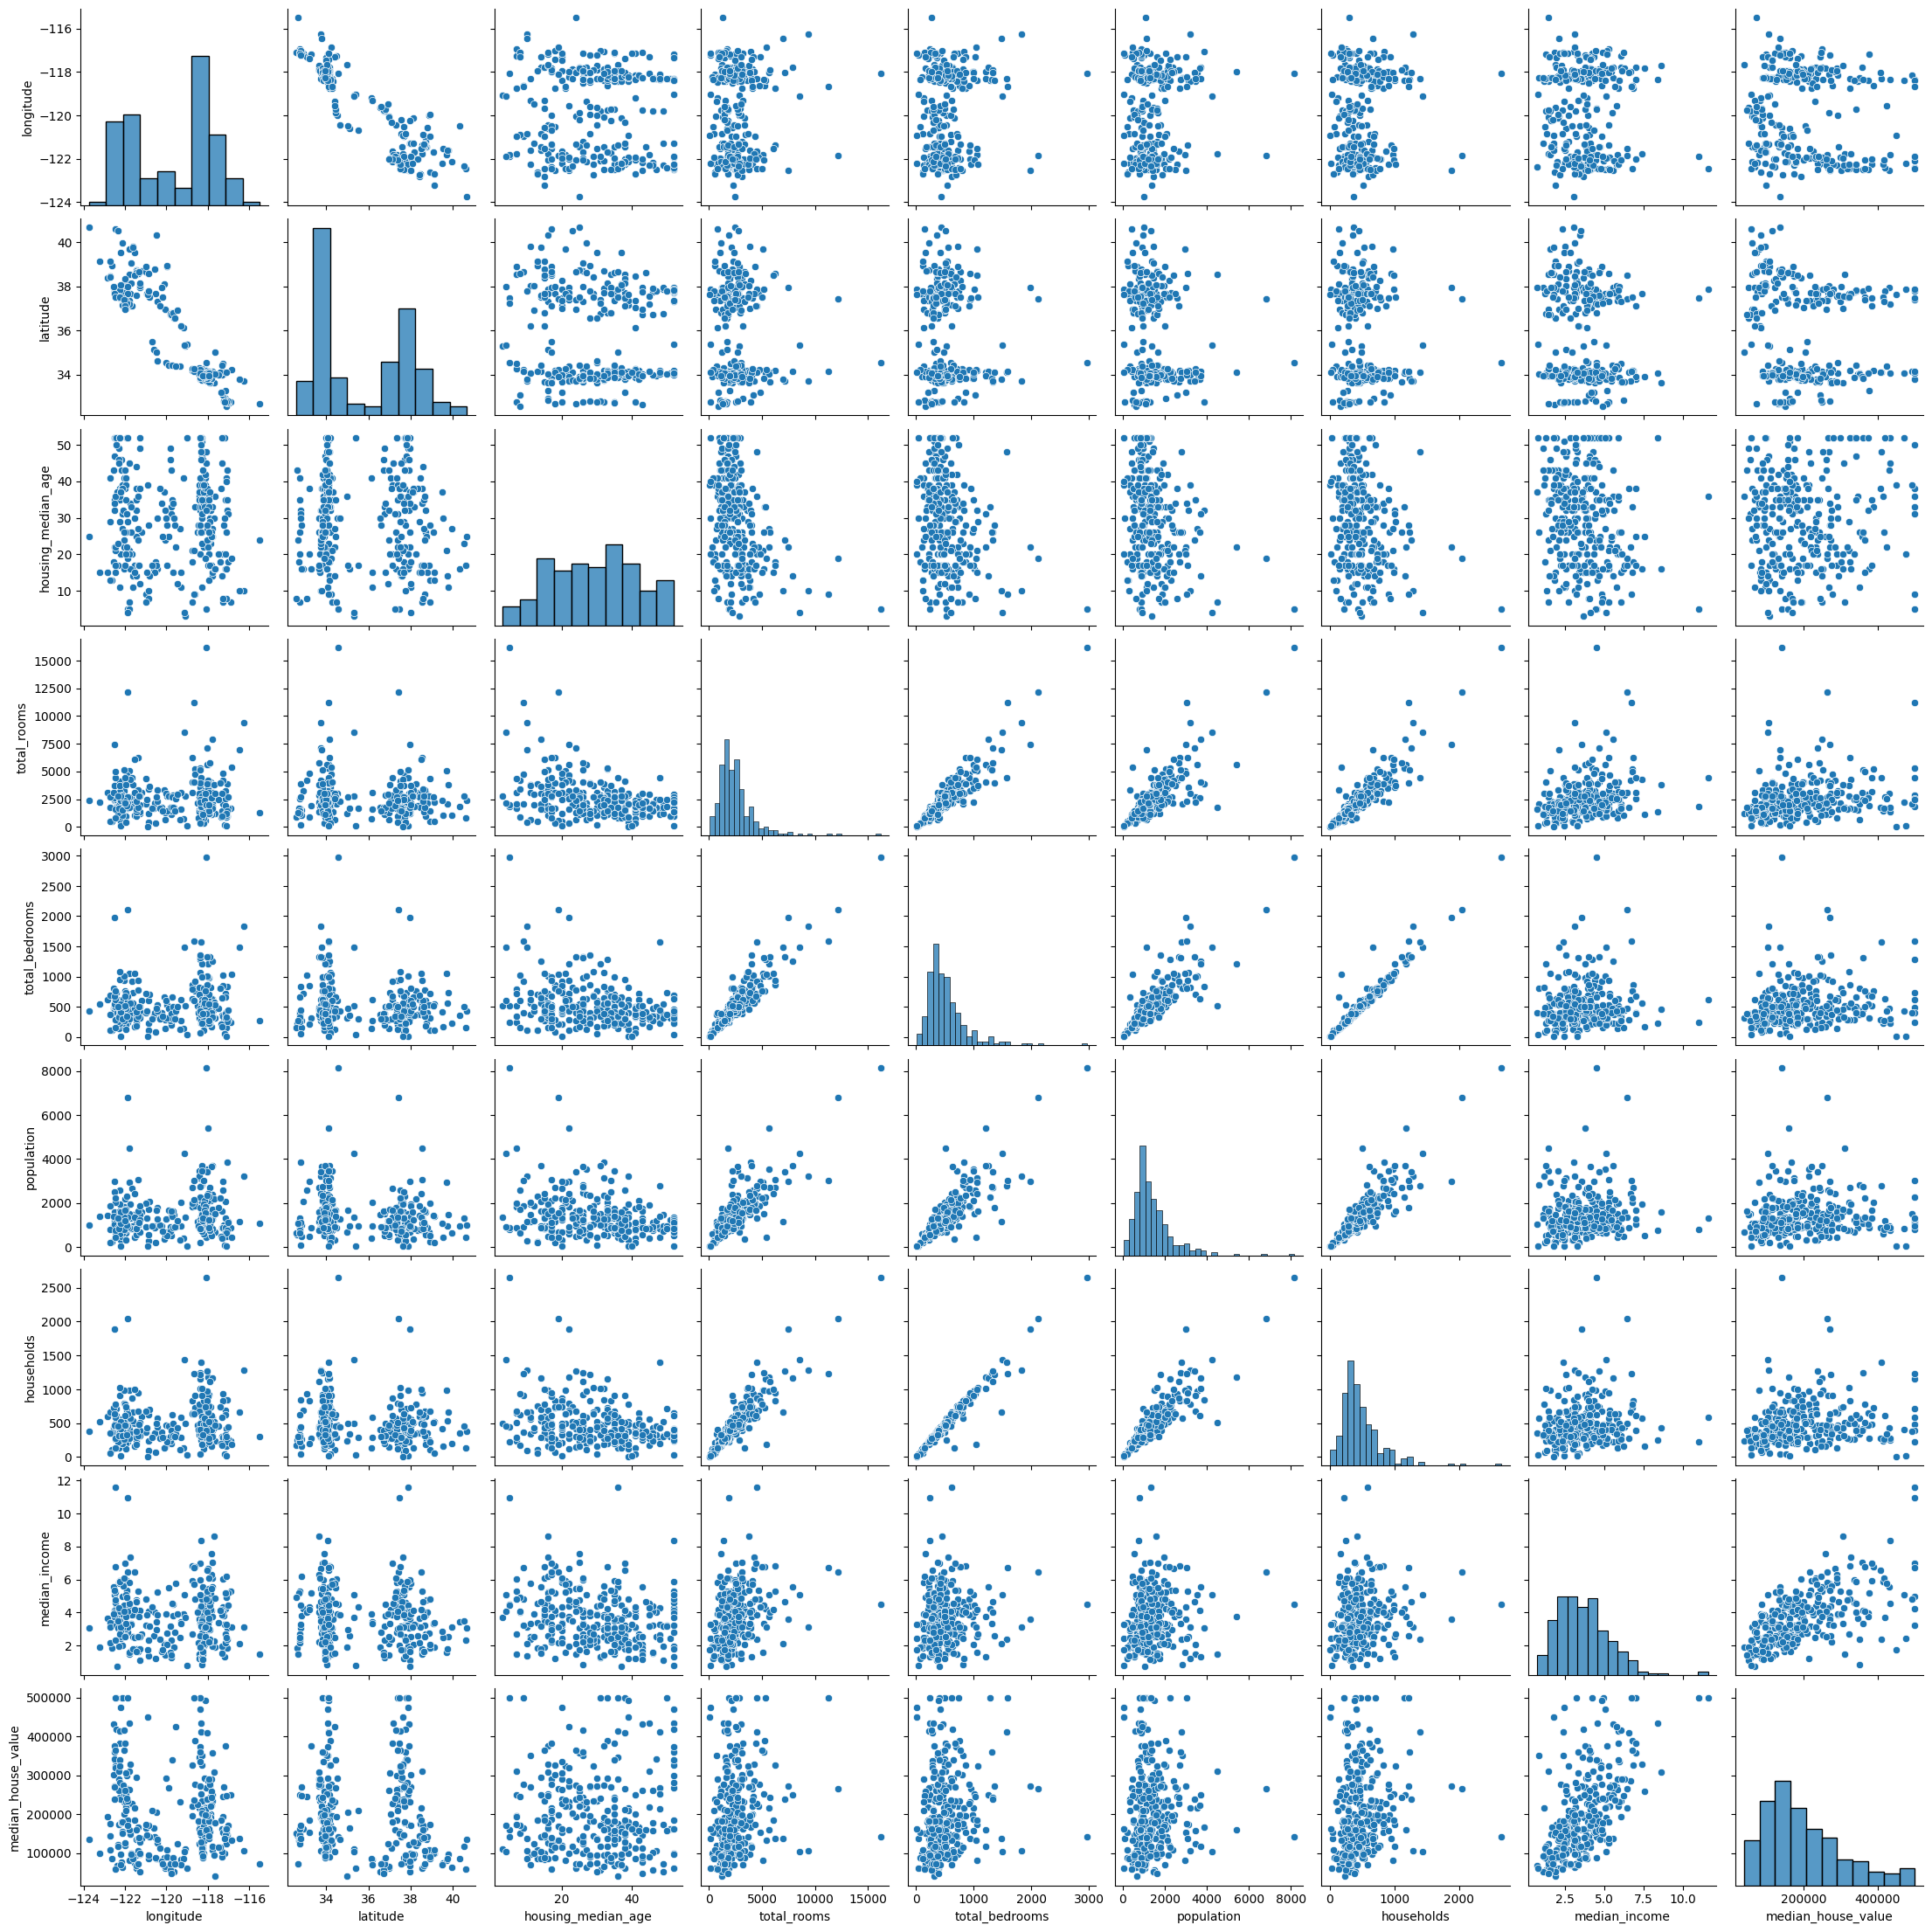

In [6]:


# Initialize Spark Session
def initialize_spark(app_name="PySpark EDA"):
    spark = SparkSession.builder.appName(app_name).getOrCreate()
    return spark

# Load Data
def load_data(spark, file_path, file_type='csv'):
    if file_type == 'csv':
        return spark.read.csv(file_path, header=True, inferSchema=True)
    elif file_type == 'json':
        return spark.read.json(file_path)
    else:
        raise ValueError("Unsupported file type")

# Basic Info
def basic_info(df, log_file):
    log_file.write("Basic Info:\n")
    df.show()
    df.printSchema()
    df.describe().show()

# Missing Values
def missing_values(df, log_file):
    log_file.write("\nMissing Values:\n")
    for col_name in df.columns:
        missing_count = df.filter(col(col_name).isNull()).count()
        log_file.write(f"{col_name}: {missing_count} missing values\n")

# Identify Numerical and Categorical Columns
def identify_columns(df, log_file):
    log_file.write("\nIdentifying Columns:\n")
    data_types = dict(df.dtypes)
    numerical_columns = [column for column, dtype in data_types.items() if dtype in ['int', 'float', 'double']]
    categorical_columns = []

    for column, dtype in data_types.items():
        if dtype == 'string':
            casted_column = df.withColumn(column, col(column).cast(FloatType()))
            non_null_count = casted_column.filter(col(column).isNotNull()).count()
            if non_null_count / df.count() > 0.95:
                numerical_columns.append(column)
            else:
                categorical_columns.append(column)

    log_file.write(f"Numerical Columns: {numerical_columns}\n")
    log_file.write(f"Categorical Columns: {categorical_columns}\n")
    return numerical_columns, categorical_columns

# Plot Distributions
def plot_distributions(df, numerical_columns):
    pandas_df = df.sample(fraction=0.1).toPandas()
    for column in numerical_columns:
        sns.histplot(pandas_df[column], kde=True)
        plt.title(f'Distribution of {column}')
        plt.show()

# Plot Categorical Columns
def plot_categorical(df, categorical_columns):
    pandas_df = df.sample(fraction=0.1).toPandas()
    for column in categorical_columns:
        sns.countplot(y=column, data=pandas_df)
        plt.title(f'Count plot of {column}')
        plt.show()

# Correlation Matrix
def correlation_matrix(df, log_file):
    log_file.write("\nCorrelation Matrix:\n")
    pandas_df = df.sample(fraction=0.1).toPandas()
    numerical_df = pandas_df.select_dtypes(include=['number'])
    corr = numerical_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()
    log_file.write(corr.to_string() + "\n")

# Outlier Detection
def detect_outliers(df, numerical_columns):
    pandas_df = df.sample(fraction=0.1).toPandas()
    for column in numerical_columns:
        sns.boxplot(x=pandas_df[column])
        plt.title(f'Boxplot of {column}')
        plt.show()

# Feature Engineering Example
def feature_engineering(df):
    if 'date_column' in df.columns:
        df = df.withColumn('year', F.year(col('date_column')))
        df = df.withColumn('month', F.month(col('date_column')))
        df = df.withColumn('day', F.dayofmonth(col('date_column')))
    return df

# Target Variable Analysis
def target_variable_analysis(df, target_column):
    sns.histplot(df.select(target_column).toPandas()[target_column], kde=True)
    plt.title(f'Distribution of {target_column}')
    plt.show()

# Pairwise Plots
def pairwise_plots(df, numerical_columns):
    pandas_df = df.sample(fraction=0.1).toPandas()
    sns.pairplot(pandas_df[numerical_columns])
    plt.show()

# Missing Value Imputation
def impute_missing_values(df, log_file):
    log_file.write("\nImputing Missing Values:\n")
    for column in df.columns:
        mean_value = df.select(mean(col(column))).collect()[0][0]
        if mean_value is not None:
            df = df.fillna({column: mean_value})
        else:
            log_file.write(f"Skipping imputation for column {column} as mean is None.\n")
    return df

# Summary Statistics by Group
def summary_statistics_by_group(df, log_file):
    log_file.write("\nSummary Statistics by Group:\n")
    try:
        categorical_column = next((col for col, dtype in df.dtypes if dtype == 'string'), None)
        numerical_column = next((col for col, dtype in df.dtypes if dtype in ['int', 'float', 'double']), None)

        if categorical_column and numerical_column:
            grouped_df = df.groupBy(categorical_column).agg(
                mean(numerical_column).alias('mean_numerical'),
                stddev(numerical_column).alias('stddev_numerical')
            )
            grouped_df.show()
            log_file.write(grouped_df.toPandas().to_string() + "\n")
        else:
            log_file.write("Not enough suitable columns found for summary statistics (need one categorical and one numerical).\n")

    except Exception as e:
        log_file.write(f"Error during summary statistics calculation: {e}\n")

# Categorical Variable Encoding
def encode_categorical(df, categorical_columns):
    from pyspark.ml.feature import StringIndexer
    indexers = [StringIndexer(inputCol=column, outputCol=column+"_indexed") for column in categorical_columns]
    from pyspark.ml import Pipeline
    pipeline = Pipeline(stages=indexers)
    df = pipeline.fit(df).transform(df)
    return df

# Detect Potential Target Variable
def detect_target_variable(df, log_file):
    numerical_columns, _ = identify_columns(df, log_file)
    if len(numerical_columns) > 0:
        target_column = numerical_columns[-1]
        log_file.write(f"Detected potential target variable: {target_column}\n")
        return target_column
    else:
        log_file.write("No numerical columns detected. Unable to identify target variable.\n")
        return None

# Full EDA Pipeline
def eda_pipeline(file_path, file_type='csv'):
    spark = initialize_spark()

    # Open log file
    with open("eda_output.txt", "w") as log_file:
        # Load data
        df = load_data(spark, file_path, file_type)

        # Basic Info
        basic_info(df, log_file)

        # Missing Values
        missing_values(df, log_file)

        # Identify Columns
        numerical_columns, categorical_columns = identify_columns(df, log_file)

        # Detect Target Variable
        target_column = detect_target_variable(df, log_file)

        # Plot Distributions for Numerical Columns
        plot_distributions(df, numerical_columns)

        # Plot Distributions for Categorical Columns
        plot_categorical(df, categorical_columns)

        # Correlation Matrix
        correlation_matrix(df, log_file)

        # Detect Outliers
        detect_outliers(df, numerical_columns)

        # Feature Engineering
        df = feature_engineering(df)

        # Target Variable Analysis
        if target_column:
            target_variable_analysis(df, target_column)

        # Pairwise Plots
        pairwise_plots(df, numerical_columns)

        # Impute Missing Values
        df = impute_missing_values(df, log_file)

        # Summary Statistics by Group
        summary_statistics_by_group(df, log_file)

        # Encode Categorical Variables
        df = encode_categorical(df, categorical_columns)

    spark.stop()

# Example usage

eda_pipeline(r'/content/sample_data/california_housing_test.csv')


FileNotFoundError: [Errno 2] No such file or directory: 'plots/distribution_AGE.png'

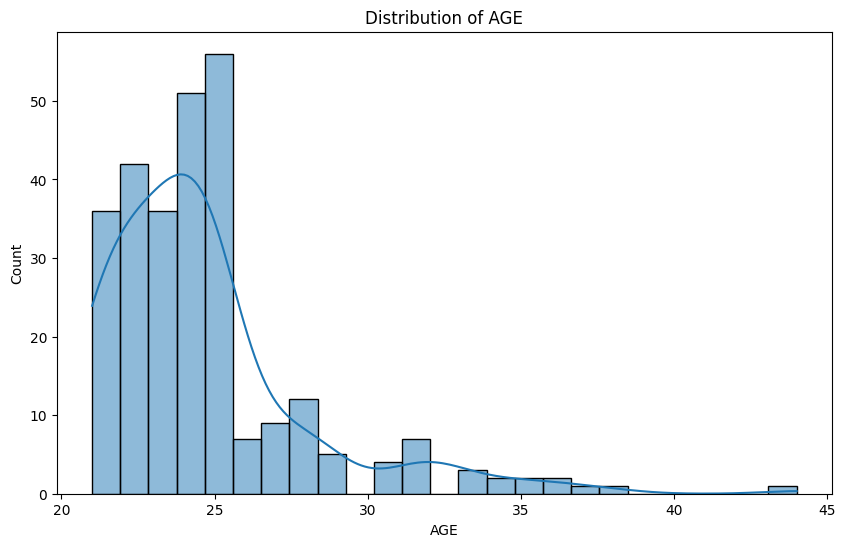

In [ ]:


# # Initialize Spark Session
# def initialize_spark(app_name="PySpark EDA"):
#     spark = SparkSession.builder.appName(app_name).getOrCreate()
#     return spark

# # Load Data
# def load_data(spark, file_path, file_type='csv'):
#     if file_type == 'csv':
#         return spark.read.csv(file_path, header=True, inferSchema=True)
#     elif file_type == 'json':
#         return spark.read.json(file_path)
#     else:
#         raise ValueError("Unsupported file type")

# # Basic Info

# def basic_info(df):
#     import io
#     buffer = io.StringIO()
#     df.toPandas().info(buf=buffer)  # Redirect output to buffer
#     basic_info_string = buffer.getvalue()
#     return basic_info_string  # Return the captured string

# # Missing Values
# def missing_values(df):
#     missing_values_html = df.select([(count(when(col(c).isNull(), c)) / count("*")).alias(c) for c in df.columns]).toPandas().to_html()
#     return missing_values_html

# # Identify Numerical and Categorical Columns
# def identify_columns(df):
#     data_types = dict(df.dtypes)
#     numerical_columns = [column for column, dtype in data_types.items() if dtype in ['int', 'float', 'double']]
#     categorical_columns = []

#     for column, dtype in data_types.items():
#         if dtype == 'string':
#             casted_column = df.withColumn(column, col(column).cast(FloatType()))
#             non_null_count = casted_column.filter(col(column).isNotNull()).count()
#             if non_null_count / df.count() > 0.95:
#                 numerical_columns.append(column)
#             else:
#                 categorical_columns.append(column)

#     return numerical_columns, categorical_columns

# # Plot Distributions
# def plot_distributions(df, numerical_columns):
#     pandas_df = df.sample(fraction=0.1).toPandas()
#     for column in numerical_columns:
#         plt.figure(figsize=(10, 6))
#         sns.histplot(pandas_df[column], kde=True)
#         plt.title(f'Distribution of {column}')
#         plt.savefig(f'plots/distribution_{column}.png')
#         plt.close()

# # Plot Categorical Columns
# def plot_categorical(df, categorical_columns):
#     pandas_df = df.sample(fraction=0.1).toPandas()
#     for column in categorical_columns:
#         plt.figure(figsize=(10, 6))
#         sns.countplot(y=column, data=pandas_df)
#         plt.title(f'Count plot of {column}')
#         plt.savefig(f'plots/count_{column}.png')
#         plt.close()

# # Correlation Matrix
# def correlation_matrix(df):
#     pandas_df = df.sample(fraction=0.1).toPandas()
#     numerical_df = pandas_df.select_dtypes(include=['number'])
#     corr = numerical_df.corr()
#     plt.figure(figsize=(12, 10))
#     sns.heatmap(corr, annot=True, cmap='coolwarm')
#     plt.title('Correlation Matrix')
#     plt.savefig('plots/correlation_matrix.png')
#     plt.close()

# # Outlier Detection
# def detect_outliers(df, numerical_columns):
#     pandas_df = df.sample(fraction=0.1).toPandas()
#     for column in numerical_columns:
#         plt.figure(figsize=(10, 6))
#         sns.boxplot(x=pandas_df[column])
#         plt.title(f'Boxplot of {column}')
#         plt.savefig(f'plots/boxplot_{column}.png')
#         plt.close()

# # Feature Engineering Example
# def feature_engineering(df):
#     if 'date_column' in df.columns:
#         df = df.withColumn('year', F.year(col('date_column')))
#         df = df.withColumn('month', F.month(col('date_column')))
#         df = df.withColumn('day', F.dayofmonth(col('date_column')))
#     return df

# # Target Variable Analysis
# def target_variable_analysis(df, target_column):
#     sns.histplot(df.select(target_column).toPandas()[target_column], kde=True)
#     plt.title(f'Distribution of {target_column}')
#     plt.savefig(f'plots/target_distribution_{target_column}.png')
#     plt.close()

# # Pairwise Plots
# def pairwise_plots(df, numerical_columns):
#     pandas_df = df.sample(fraction=0.1).toPandas()
#     sns.pairplot(pandas_df[numerical_columns])
#     plt.savefig('plots/pairwise_plots.png')
#     plt.close()

# # Missing Value Imputation
# def impute_missing_values(df):
#     for column in df.columns:
#         mean_value = df.select(mean(col(column))).collect()[0][0]
#         if mean_value is not None:
#             df = df.fillna({column: mean_value})
#     return df

# # Summary Statistics by Group
# def summary_statistics_by_group(df):
#     try:
#         categorical_column = next((col for col, dtype in df.dtypes if dtype == 'string'), None)
#         numerical_column = next((col for col, dtype in df.dtypes if dtype in ['int', 'float', 'double']), None)

#         if categorical_column and numerical_column:
#             grouped_df = df.groupBy(categorical_column).agg(
#                 mean(numerical_column).alias('mean_numerical'),
#                 stddev(numerical_column).alias('stddev_numerical')
#             )
#             return grouped_df.toPandas().to_html()
#         else:
#             return "Not enough suitable columns found for summary statistics (need one categorical and one numerical)."

#     except Exception as e:
#         return f"Error during summary statistics calculation: {e}"

# # Categorical Variable Encoding
# def encode_categorical(df, categorical_columns):
#     from pyspark.ml.feature import StringIndexer
#     indexers = [StringIndexer(inputCol=column, outputCol=column+"_indexed") for column in categorical_columns]
#     from pyspark.ml import Pipeline
#     pipeline = Pipeline(stages=indexers)
#     df = pipeline.fit(df).transform(df)
#     return df

# # Detect Potential Target Variable
# def detect_target_variable(df):
#     numerical_columns, _ = identify_columns(df)
#     if len(numerical_columns) > 0:
#         target_column = numerical_columns[-1]
#         return target_column
#     else:
#         return None

# # Full EDA Pipeline
# def eda_pipeline(file_path, file_type='csv'):
#     spark = initialize_spark()

#     # Load data
#     df = load_data(spark, file_path, file_type)

#     # Generate HTML report
#     with open("eda_report.html", "w") as report:
#         report.write("<html><head><title>EDA Report</title></head><body>")

#         # Basic Info
#         report.write("<h1>Basic Info</h1>")
#         report.write(basic_info(df))

#         # Missing Values
#         report.write("<h1>Missing Values</h1>")
#         report.write(missing_values(df))

#         # Identify Columns
#         numerical_columns, categorical_columns = identify_columns(df)

#         report.write("<h1>Numerical Columns</h1>")
#         report.write(f"<p>{numerical_columns}</p>")

#         report.write("<h1>Categorical Columns</h1>")
#         report.write(f"<p>{categorical_columns}</p>")

#         # Detect Target Variable
#         target_column = detect_target_variable(df)
#         report.write("<h1>Detected Target Variable</h1>")
#         report.write(f"<p>{target_column}</p>")

#         # Plot Distributions for Numerical Columns
#         plot_distributions(df, numerical_columns)
#         report.write("<h1>Numerical Distributions</h1>")
#         for column in numerical_columns:
#             report.write(f'<img src="plots/distribution_{column}.png" width="600"><br>')

#         # Plot Distributions for Categorical Columns
#         plot_categorical(df, categorical_columns)
#         report.write("<h1>Categorical Distributions</h1>")
#         for column in categorical_columns:
#             report.write(f'<img src="plots/count_{column}.png" width="600"><br>')

#         # Correlation Matrix
#         correlation_matrix(df)
#         report.write("<h1>Correlation Matrix</h1>")
#         report.write('<img src="plots/correlation_matrix.png" width="600"><br>')

#         # Detect Outliers
#         detect_outliers(df, numerical_columns)
#         report.write("<h1>Outliers</h1>")
#         for column in numerical_columns:
#             report.write(f'<img src="plots/boxplot_{column}.png" width="600"><br>')

#         # Feature Engineering
#         df = feature_engineering(df)

#         # Target Variable Analysis
#         if target_column:
#             target_variable_analysis(df, target_column)
#             report.write("<h1>Target Variable Analysis</h1>")
#             report.write(f'<img src="plots/target_distribution_{target_column}.png" width="600"><br>')

#         # Pairwise Plots
#         pairwise_plots(df, numerical_columns)
#         report.write("<h1>Pairwise Plots</h1>")
#         report.write('<img src="plots/pairwise_plots.png" width="600"><br>')

#         # Impute Missing Values
#         df = impute_missing_values(df)

#         # Summary Statistics by Group
#         report.write("<h1>Summary Statistics by Group</h1>")
#         report.write(summary_statistics_by_group(df))

#         # Encode Categorical Variables
#         df = encode_categorical(df, categorical_columns)

#         report.write("</body></html>")

#     spark.stop()

# # Example usage
# eda_pipeline(r'/Salary Prediction of Data Professions 2.csv')
